# Fit Detection

### Imports

In [1]:
import json
import scipy
import numpy as np
import menpo.io as mio

from pathlib import Path
from menpo.image import Image
from menpo.shape import PointCloud

import deepmachine as dm
from deepmachine import contrib
from deepmachine import utils

%matplotlib inline

D:\Anaconda2\envs\gitdev\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### Model

In [2]:
# model_path = '/homes/yz4009/db/ckpt_all/Pose/ckpt/inception_hourglass_pose/model.ckpt-56023'
model_path = 'D:/pretrained_models/model.ckpt-574050'
dense_pose_net = contrib.get_dense_pose_net_old()
dense_pose_net.restore_path = model_path

In [11]:
def fit(image_path, bbox_list):
    image = mio.import_image(image_path)
    bbox = PointCloud(np.array(bbox_list).reshape(-1,2)[:,::-1]).bounding_box()
    
    cimg, trans, *_ = utils.crop_image_bounding_box(image, bbox, [256, 256], base=256)
    lms_hm_prediction, states = dense_pose_net.run_one(
        cimg.pixels_with_channels_at_back().astype(np.float32)[None, ...]
    )
    
    bsize,h,w,n_ch = lms_hm_prediction.shape
    lms_hm_prediction_filter = np.stack(list(map(
                                lambda x: scipy.ndimage.filters.gaussian_filter(*x),
                                zip(lms_hm_prediction.transpose(0,3,1,2).reshape(-1,h,w), [5] * (bsize * n_ch)))))

    hs = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 2), 1)
    ws = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 1), 1)
    pts_predictions = np.stack([hs,ws]).T
    

    return trans.apply(pts_predictions), cimg, pts_predictions

### Data

In [4]:
image_path = Path('./static/images/image1.jpg')
json_path = image_path.with_suffix('.json')
anno = json.load(open(str(json_path), 'r'))

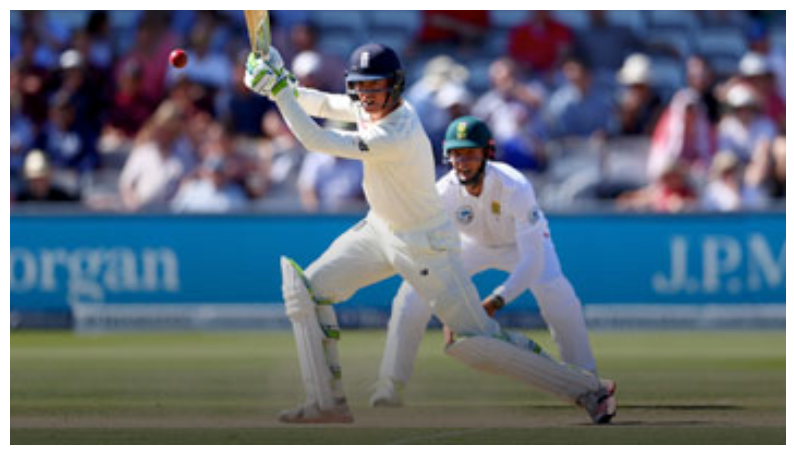

In [5]:
image = mio.import_image(image_path)
image.view()

In [12]:
lms, cimg, clms = fit(image_path, anno[0]['bbox'])

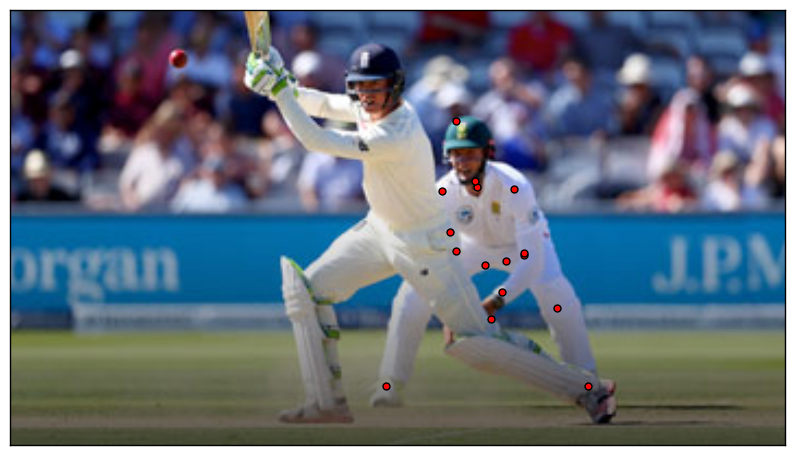

In [13]:
mio.import_image(image_path).view()
PointCloud(lms).view()

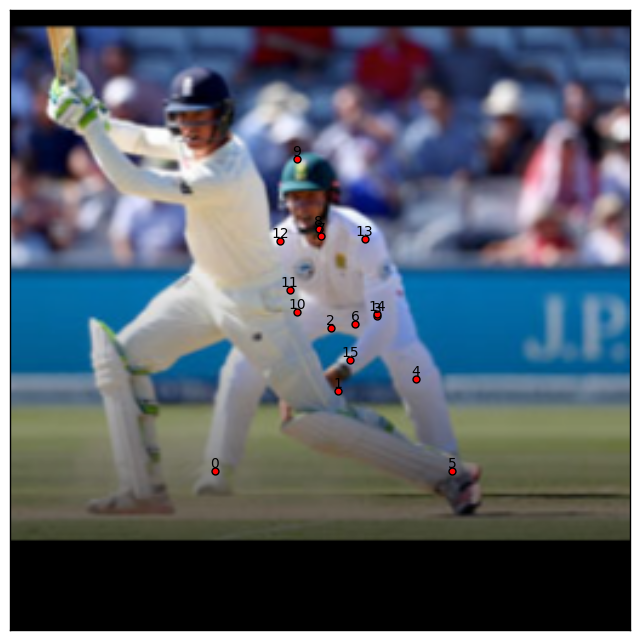

In [15]:
cimg.view()
PointCloud(clms).view(render_numbering=True)